In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

In [5]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

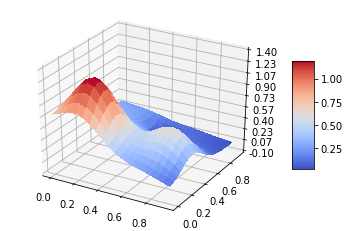

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [7]:
def CreateDesignMatrix_X(x, y, n = 5):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [8]:
n_x = 100   # number of points
m = 5        # degree of polynomial

# sort the random values, else your fit will go crazy
x = np.sort((np.random.uniform(0, 1, n_x)))
y = np.sort(np.random.uniform(0, 1, n_x))

# use the meshgrid functionality, very useful
x, y = np.meshgrid(x,y)
z = FrankeFunction(x,y)

#Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
n = int(len(x_1))
z_1 = np.ravel(z) + np.random.random(n) * 1
z_true = np.ravel(z)


# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1 is the function that gives the data, X is the design matrix

Then inverse the matrix and find β, and perform the linear regression (where ztilde is the model):

In [9]:
z_true.shape

(10000,)

In [10]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

beta_t = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_true)
ztilde_t = X @ beta_t

In [11]:
ztilde_t.shape

(10000,)

ValueError: Argument Z must be 2-dimensional.

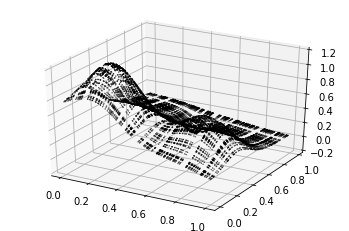

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_zlim3d(-0.2, 1.2)

ax1.scatter(x, y, z, alpha=1, s=0.1, color='black')
ax1.plot_surface(x, y, ztilde_t, alpha=0.5, cmap=cm.coolwarm)

plt.title(f'Polynomial degree')
plt.show()

Find the confidence intervals of the parameters β by computing their variances:

In [14]:
np.var(beta)

721.7794969852848

?????

Next we evaluate the Mean Squared error (MSE) and the R2 score function for the model (ztilde):

In [12]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

print(MSE(z_1, ztilde))

0.0852287302908417


The MSE is ideally zero, since the smaller the value the better the fit. Here we observe an MSE of 0.09, which is pretty low, therefore indicating a good fit of the model.

In [13]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

print(R2(z_1, ztilde))

0.47382371606390195


The R2 score gives the coefficient of determination, which indicates how well the model predicts future samples. The best score would be 1.0. Given that the model has a score of 0.5 , this indicates that the model would explain 50% of the future samples correct, which is quite low (not sure if we can say this though).

# Part b) Resampling techniques, adding more complexity

First split the dataset in training data and test data

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [15]:
X_train, X_test, z_train, z_test = train_test_split(X, z_1, test_size=0.2)

In [16]:
# Get the new model from the training data
beta2 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta2

# And the predictions for the test data
zpredict = X_test @ beta2

In [17]:
print("Training MSE:", MSE(z_train, ztilde1))
print("Test MSE:", MSE(z_test, zpredict))

Training MSE: 0.08503023986459882
Test MSE: 0.08633240430937583


In [18]:
print("Training R2:", R2(z_train, ztilde1))
print("Test R2:", R2(z_test, zpredict))

Training R2: 0.4784631649581632
Test R2: 0.4521229846969568


K-fold cross validation

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [20]:
def cross_validation(x, y, k):
    n = len(x)
    #np.random.shuffle(x)
    #np.random.shuffle(y)
    r2_test = []
    mse_test = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
    
    r2_test = np.array(r2_test)
    print("R2-Score: %0.2f (+/- %0.2f)" % (r2_test.mean(), r2_test.std() * 2))
        
    return r2_test, mse_test

In [21]:
r, m = cross_validation(X, z_1, 4)

R2-Score: -0.13 (+/- 0.77)


In [22]:
print(np.mean(m))

0.252193005440065


Perform the cross-validation to estimate R2 and MSE

In [23]:
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

In [24]:
linreg = skl.LinearRegression().fit(X_train, z_train)
ztilde2 = linreg.predict(X_test)

In [25]:
scores = cross_val_score(linreg, X_test, z_test, cv = kfold)
print(scores)

[0.51851306 0.4245958  0.34336229 0.55434782 0.41698585 0.41974189
 0.41942175 0.46825406 0.35686631 0.45175708]


In [26]:
print("R2-Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2-Score: 0.44 (+/- 0.12)


In [27]:
scores_mse = cross_val_score(linreg, X_test, z_test, scoring='neg_mean_squared_error', cv=kfold)

In [28]:
estimated_mse_sklearn = np.mean(-scores_mse)
print(estimated_mse_sklearn)

0.0867434799856747


# Part C) Bias-variance tradeoff

# Part D) Ridge Regression on the Franke function with resampling

In [29]:
_lambda = 1

In [30]:
betaridge = np.linalg.inv(X_train.T.dot(X_train)+(_lambda*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
zridge = X_train @ betaridge

ridge_predict = X_test @ betaridge

In [31]:
print("var(beta) OLS:", np.var(beta))
print("var(beta) ridge:", np.var(betaridge))

var(beta) OLS: 577.6110177919721
var(beta) ridge: 0.6607739770424157


In [32]:
print("MSE OLS:", MSE(z_test, zpredict))
print("MSE ridge:", MSE(z_test, ridge_predict))

MSE OLS: 0.08633240430937583
MSE ridge: 0.09082115915370853


In [33]:
print("R2 OLS:", R2(z_test, zpredict))
print("R2 Ridge:", R2(z_test, ridge_predict))

R2 OLS: 0.4521229846969568
R2 Ridge: 0.42364276683241586


In [37]:
nlambdas = 500
lambdas = np.logspace(-7, 3, nlambdas)

k = 10
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    betaridge1 = np.linalg.inv(X_train.T.dot(X_train)+(lmb*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        Xtrain = X[train_inds]
        ztrain = z_1[train_inds]

        Xtest = X[test_inds]
        ztest = z_1[test_inds]
        
        zpred = Xtest @ betaridge1

        scores_KFold[i,j] = np.sum((zpred - ztest)**2)/np.size(zpred)

        j += 1
    i += 1

X_centered = X_train - np.mean(X_train,axis=0)
z_centered = z_train - np.mean(z)
estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

Remove intercept column! Use centered data because now the intercept is penalized as well. Scikitlearn does this automatically, so you can test with sklearn. however this expects you to remove the intercept column as well. 

In [38]:
np.mean(scores_KFold)

0.110192300523367

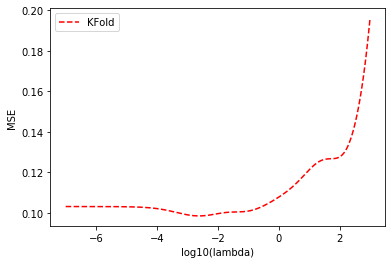

In [39]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [110]:
estimated_mse_sklearn = np.zeros(100)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    ridge.fit(X_train, z_train)

    estimated_mse_folds = cross_val_score(ridge, X, z_1[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

In [107]:
poly = PolynomialFeatures(degree = 5)

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        Xtrain = X[train_inds]
        ztrain = z_1[train_inds]

        Xtest = X[test_inds]
        ztest = z_1[test_inds]

        ridge.fit(Xtrain, ztrain[:, np.newaxis])

        zpred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((zpred - ztest[:, np.newaxis])**2)/np.size(zpred)

        j += 1
    i += 1

print(np.mean(scores_KFold))
estimated_mse_sklearn1 = np.mean(scores_KFold, axis = 1)

0.11976813687598911


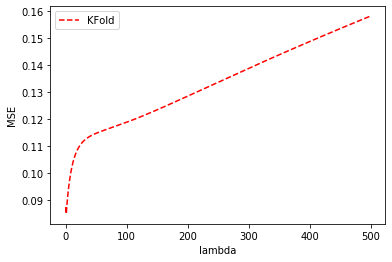

In [155]:
plt.figure()

plt.plot(lambdas, estimated_mse_KFold, 'r--', label = 'KFold')
#plt.plot(lambdas, estimated_mse_sklearn, label = 'cross_val_score')
#plt.plot(lambdas, estimated_mse_sklearn1, label = 'Model_predict')

plt.xlabel('lambda')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Part E) Lasso Regression on the Franke function with resampling


In [28]:
from sklearn.preprocessing import PolynomialFeatures

In [29]:
#polynomial_features = PolynomialFeatures(degree=5)
#X_poly = polynomial_features.fit_transform(X)

In [30]:
clf_lasso = skl.Lasso(alpha=0.001).fit(X_train, z_train)
zlasso = clf_lasso.predict(X_test)

In [31]:
print(MSE(z_test, zlasso))

0.09612652901085116


In [32]:
print(R2(z_test, zlasso))

0.4284944549176707


The smaller alpha gets, the lower the MSE and the higher the R2 score.